In [1]:
# Include libraries
from ipywidgets import FloatProgress
from IPython.display import display
from warnings import simplefilter
import matplotlib.pyplot as plt
# Stop warnings from printing
simplefilter('ignore')
from copy import deepcopy
import numpy as np
import cpuinfo
import sys
import math
import time
import os

# Load pytorch
import torch
import torchvision

In [2]:
from Scripts.pytorchHelpers import dataLoading, visual, devices
from Scripts import VGG16FCN

In [3]:
device = devices.getDevice()

Using Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz


In [4]:
# Instance a FCN base on VGG16
FCN8 = VGG16FCN.FCN8(2)
# Build a collection of batch iomage loaders
loaders = dataLoading.buildDataloaders(2, 0.2, '\\Data\\data_road\\', 'training\\raw\\', 'training\\gt\\', 'testing\\')

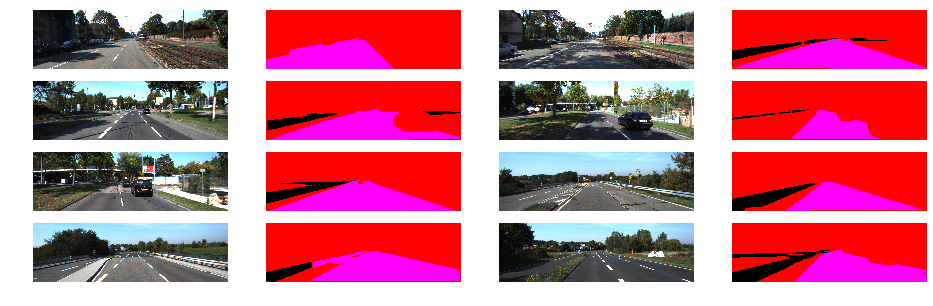

In [5]:
# Get current working directory
path =  os.getcwd() + "\Data\data_road"
pathRaw = path + "\\training\\raw\\image_2"
pathGroundTruth = path + "\\training\\gt\\gt_image_2"
groundTruthFiles = os.listdir(pathGroundTruth)
rawFiles = os.listdir(pathRaw)

# Print examples of the images
Figure = plt.figure(figsize=(16, 5))
for i in range(16):
    if (i % 2 != 0):
        tmpFilePath = pathGroundTruth + "\\" + groundTruthFiles[i]
    else:
        tmpFilePath = pathRaw + "\\" + rawFiles[i]
    
    tmpImage = plt.imread(tmpFilePath)
    Figure.add_subplot(4, 4, i+1).axis('off')
    plt.imshow(tmpImage)

0 torch.Size([2, 3, 375, 1242])
0 torch.Size([2, 3, 375, 1242])


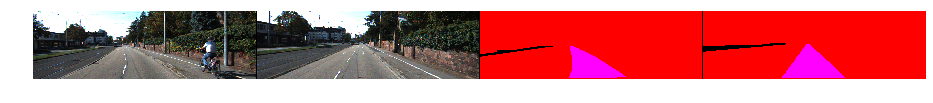

In [6]:
# Confirming that sequential loaders are working
for batch, gtrawBatched in enumerate(zip(loaders['train'], loaders['trainGT'])):
    print(batch, gtrawBatched[0][0].shape)
    print(batch, gtrawBatched[1][0].shape)
    # generate 2nd batch and display it
    if batch == 0:
        plt.figure(figsize=(16, 14))
        img = visual.tensorToNumpy(torch.cat((gtrawBatched[0][0], gtrawBatched[1][0])))
        plt.axis('off')
        plt.imshow(img)
        plt.savefig('Figures\\BatchExample.png')
        break 

In [7]:
# Optimser, Scheduler and Loss Function
optimiser = torch.optim.SGD(FCN8.parameters(), lr = 0.02)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, 20)
lossFN = torch.nn.MultiLabelSoftMarginLoss()

In [8]:
def trainFCN(network, lossFn, optimiser, scheduler, NumberOfEpochs, batchLoader):
    start = time.time()
    # Reset best model found and the highest validation accuracy seen
    BestModel = deepcopy(network.state_dict())
    HighestAcc = 0.0
    # Push the network to the active device
    if torch.cuda.device_count() > 1:
        # Use Multiple GPUs if available
        network = torch.nn.DataParallel(network)
    
    network.to(device)
    
    # Make some lists to track loss and accuracy
    trainingLoss = list()
    validationLoss = list()
    trainingAcc = list()
    validationAcc = list()
    
    # Preform training and validation NumberOfEpochs times
    for epoch in range(1, NumberOfEpochs + 1):
        print('Epoch: {}/{}'.format(epoch, NumberOfEpochs))

        # Each epoch has a training and validation phase
        for stage in ['train', 'trainVali', 'vali']:
            if stage == 'train':
                # Print a progress bar
                bar = FloatProgress(min = 0, max = len(batchLoader['train'].dataset) +
                      len(batchLoader['train'].dataset) + len(batchLoader['vali'].dataset))
                display(bar)
                
                scheduler.step()
                # The network will be updated
                network.train()  
            else:
                # The network will not be updated
                network.eval()   
            
            # Reset evaluation metrics
            loss = 0.0
            correct = 0

            # Iterate over data.
            for gtrawBatched in zip(batchLoader['train'], batchLoader['trainGT']):
                bar.value += gtrawBatched[0][0].shape[0]
                # Sends the current batch of images/GTs to the 
                # active processor
                images = gtrawBatched[0][0].to(device)
                labels = gtrawBatched[1][0].to(device)

                # set the optimisers gradient to zero
                optimiser.zero_grad()

                # forward
                # track history while trainning
                with torch.set_grad_enabled(stage == 'train'):
                    # Use the model on the batch
                    if stage == 'train':
                        output, _ = network(images)
                    else:
                        output = network(images)
                    # Extract the label predictions from the output
                    # by ignoring all other returns and using the maximum 
                    # output as the precited label
                    _, predictions = torch.max(output, 1)
                    lossValue = lossFn(output, labels)

                    # If we are training, back propagate the loss
                    #  and advance the optimiser
                    if stage == 'train':
                        # Propagrate the loss back through the network
                        lossValue.backward()
                        # Step the optimiser forward using the current
                        # gradient
                        optimiser.step()

                # Add to evaluation metrics
                loss += lossValue.item() * images.size(0)
                correct += torch.sum(predictions == labels.data)
                
                
            # Calulcate the total loss and accuracy for the batch
            epochLoss = loss / imageSetSizes[stage]
            epochAcc = correct.double() / imageSetSizes[stage]
            
            if stage == 'trainVali':
                print('Training')
                trainingAcc.append(epochAcc)
                trainingLoss.append(epochLoss)
                print('Loss: {:.4f} Accuracy: {:.4f}'.format(epochLoss, epochAcc))
                
            if stage == 'vali':
                print('Validation')
                validationAcc.append(epochAcc)
                validationLoss.append(epochLoss)
                print('Loss: {:.4f} Accuracy: {:.4f}'.format(epochLoss, epochAcc))
            
            
            # Deepcopy the network if its better than the current best
            if stage == 'vali' and epochAcc >= HighestAcc:
                HighestAcc = epochAcc
                bestModel = deepcopy(network.state_dict())
                
        
        print('='*30)
        
    end = time.time()
    runtime = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.2f}s'.format(runtime//(60*60), (runtime%(60*60))//60, runtime%60))
    print('Best val Acc: {:.4f}%'.format(HighestAcc*100))

    # Save best model and Final model
    torch.save(network.state_dict(), os.getcwd + 'Models\\fineTunedCNN-Final.pwf')
    network.load_state_dict(bestModel)
    torch.save(network.state_dict(), os.getcwd + 'Models\\fineTunedCNN-Final.pwf')
    
    # Clear the GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return trainingLoss, trainingAcc, validationLoss, validationAcc

In [9]:
trainFCN(FCN8, lossFN, optimiser, scheduler, 2, loaders)

Epoch: 1/2


FloatProgress(value=0.0, max=867.0)

RuntimeError: The size of tensor a (76) must match the size of tensor b (77) at non-singleton dimension 3

In [10]:
print(FCN8)

FCN8(
  (downSample1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (downS